# **COMP41680 - Sample API Assignment**

### Name: Christopher Hayes
### Student Number: 13333061

Firs the necessary libraries were imported for use later.

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
import itertools
import nltk
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score

### Confusion Matrix Function

SciKit Learn function to plot a confusion matrix with in a blue shading. Function can be found on SciKit learns website *http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html*

In [2]:
# import all of the scikit-learn evaluation functionality
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Part 1 - Data Collection

Part 1 deals with the collection and storage of data in text files.

### Scrape webpage for links to each monthly articles.

BeutifulSoup is used to parse the HTML file and each month is stored in an array

In [3]:
# Use BeautifulSoup to clean up HTML file
link = "http://mlg.ucd.ie/modules/COMP41680/archive/index.html"
response = urllib.request.urlopen(link)
html = response.read().decode()

# Clean up HTML
soup = BeautifulSoup(html, 'html.parser')           

months = []
# Retrieve URL where monthly articles are stored
for link in soup.body.ul.find_all('a'):
    months.append(link.get('href'))

### Retrieve individual article links and store categories

Each article link is scraped from the webpage and stored in an array. Each category is stored in a text file.

In [4]:
article_links = []
article_categories = []

# Retrieve article categories and links
for month_link in months:
    link = "http://mlg.ucd.ie/modules/COMP41680/archive/"+month_link
    response = urllib.request.urlopen(link)
    html = response.read().decode()
    soup = BeautifulSoup(html, 'html.parser')

    # Retrieve category and store in array
    for link in soup.body.tbody.find_all('td'):
        if link['class'] == ['category']:
            if link.get_text()[1:] != 'N/A':
                article_categories.append(link.get_text()[1:])
                
        # Store article link in another array
        try:
            article_links.append(link.a.get('href'))
        except:
            continue

# Error check to make sure article links and categories match up
if len(article_links) != len(article_categories):
    print('Error! Article length and article categories must be the same length')

# Write categories to a seperate file
Article_Categories_file = open('Article_Categories.txt', 'w')
for category in article_categories:
    Article_Categories_file.write("%s\n" % category)
Article_Categories_file.close()

### Retrieve HTML body text

The text body for each article is retrieved and concatenated to one large string. This string is then written to an output .txt file. Each article in the .txt file is seperated by a carriage return '\n'. 

In [5]:
# Footer of each article
footer = ['Return', 'to', 'article', 'search', 'results']
article_text = []


# Retrieve article body text
for link in article_links:
    string = []
    link = "http://mlg.ucd.ie/modules/COMP41680/archive/"+link
    response = urllib.request.urlopen(link)
    html = response.read().decode()
    soup = BeautifulSoup(html, 'html.parser')
    
    # Add the title to the string
    string += soup.body.h2.get_text().split(" ")
    
    # If the text is the footer or empty continue, otherwise store text in string
    # array. 
    for i in soup.body.find_all('p'):
        if i.get_text().split(" ") == [''] or i.get_text().split(" ") == footer:
            continue
        else:
            # Write body
            string += i.get_text().split(" ")
    
    # Store text data in array with each article seperated by a carriage return
    string += '\n'
    article_text.append(' '.join(string))

    
# Used to write strings to a .txt file without encoding problems
import string

# Write body to .txt file
Article_Body = open('Article_Body_Text.txt', 'w')
for item in article_text:
    # Write to body text file if the string can be written with the appropriate encoding
    Article_Body.write("".join(i for i in item if i in string.printable))
Article_Body.close()

## Part 2 - Text Classification

### Create target indices

Create class indices based on the article categories

In [6]:
# Define target names
target = []
target_names = ['technology', 'business', 'sport']
Article_Categories = open('Article_Categories.txt','r')

# Assign index depending category
for i in Article_Categories:
        if i == 'technology\n':
            target.append(0)
        elif i == 'business\n':
            target.append(1)
        elif i == 'sport\n':
            target.append(2)
        else:
            print("Not added")

Article_Categories.close()

### Create Training Document Term Matrix

The text bodies are read in from the .txt file and split in to training and test sets. Using a lemma tokenizer the training dataset is converted to a document term matrix.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# define the lemma tokenizer function
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens


# Open body text file and store each article in array
Article_Body = open('Article_Body_Text.txt', 'r')
articles = []

# Covnert to lowercase
for i in Article_Body:
    articles.append(i.lower())

# Create a lemma tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=lemma_tokenizer, stop_words="english", min_df=4)

# Create training dataset (80%) and test dataset (20%)
from sklearn.model_selection import train_test_split
dataset_train, dataset_test, target_train, target_test = train_test_split(articles, target, test_size=0.2)

# Create the document term matrix
train_X = vectorizer.fit_transform(dataset_train)


## Nearest Neighbour Classifier


Use the nearest neighbour classifier to create a model from the training data and predict the categories of the test dataset.

In [8]:
# Fit the training  dataset with K = 3 nearest neighbours
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

model.fit(train_X, target_train)

# Create a document term matrix with test dataset
test_X = vectorizer.transform(dataset_test)

# Make prediction
predicted_KNN = model.predict(test_X)


### Plot Confusion matrix and Cross Validation

KNN: Mean cross-validation accuracy = 0.9510
Confusion matrix, without normalization
[[ 88   2   1]
 [  2  86   0]
 [  0   3 100]]
Normalized confusion matrix
[[ 0.97  0.02  0.01]
 [ 0.02  0.98  0.  ]
 [ 0.    0.03  0.97]]


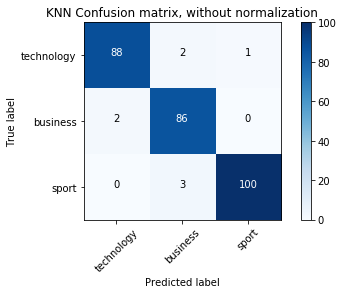

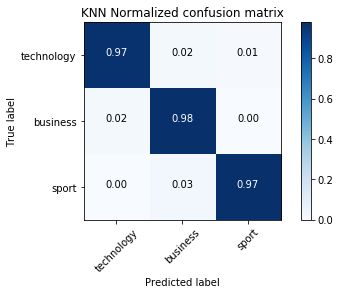

In [9]:
# Compute confusion matrix with predicted and actual terms
cnf_matrix_KNN = confusion_matrix(target_test, predicted_KNN)
np.set_printoptions(precision=2)

# Cross Validation
acc_scores_KNN =  cross_val_score(model, train_X, target_train, cv=50, scoring="accuracy")
print("KNN: Mean cross-validation accuracy = %.4f" % acc_scores_KNN.mean() )

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_KNN, classes=target_names,
                      title='KNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_KNN, classes=target_names, normalize=True,
                      title='KNN Normalized confusion matrix')

plt.show()

## Naive Bayes

Use the Naive Bayes classifier to create a model from the training data and predict the categories of the test dataset.

In [10]:
from sklearn.naive_bayes import MultinomialNB
model_bayes = MultinomialNB()

# Build a Bayes model with training data
model_bayes.fit(train_X, target_train)

# Transform test dataset to a document term matrix and predict results
test_X_Bayes = vectorizer.transform(dataset_test)
predicted_bayes = model_bayes.predict(test_X_Bayes)

### Plot Confusion matrix and Cross Validation

Bayes: Mean cross-validation accuracy = 0.9778
Confusion matrix, without normalization
[[ 89   2   0]
 [  1  87   0]
 [  0   1 102]]
Normalized confusion matrix
[[ 0.98  0.02  0.  ]
 [ 0.01  0.99  0.  ]
 [ 0.    0.01  0.99]]


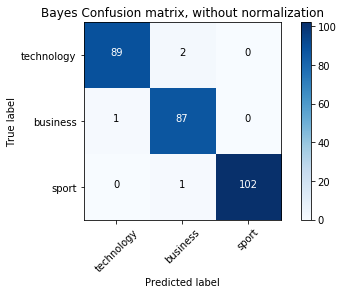

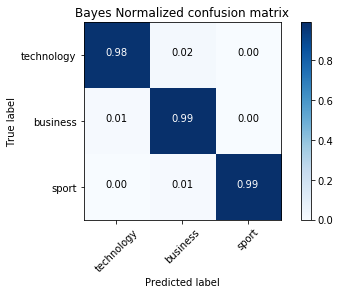

In [11]:
# Compute confusion matrix with predicted and actual terms
cnf_matrix_Bayes = confusion_matrix(target_test, predicted_bayes)
np.set_printoptions(precision=2)

# Cross Validation
acc_scores_Bayes =  cross_val_score(model_bayes, train_X, target_train, cv=50, scoring="accuracy")
print("Bayes: Mean cross-validation accuracy = %.4f" % acc_scores_Bayes.mean() )

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_Bayes, classes=target_names,
                      title='Bayes Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_Bayes, classes=target_names, normalize=True,
                      title='Bayes Normalized confusion matrix')

plt.show()

## Logistic Regression

Use the Logistic Regression classifier to create a model from the training data and predict the categories of the test dataset.

In [12]:
from sklearn import linear_model
model_logistic = linear_model.LogisticRegression()
model_logistic.fit(train_X, target_train)
test_X_Log = vectorizer.transform(dataset_test)
predicted_Log = model_logistic.predict(test_X_Log)

### Compute Confusion Matrix

Logistic: Mean cross-validation accuracy = 0.9768
Confusion matrix, without normalization
[[ 88   3   0]
 [  0  88   0]
 [  0   1 102]]
Normalized confusion matrix
[[ 0.97  0.03  0.  ]
 [ 0.    1.    0.  ]
 [ 0.    0.01  0.99]]


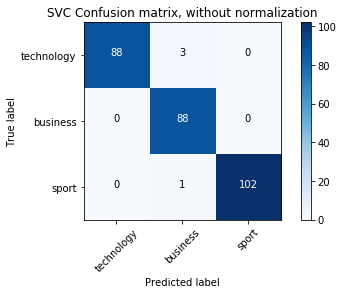

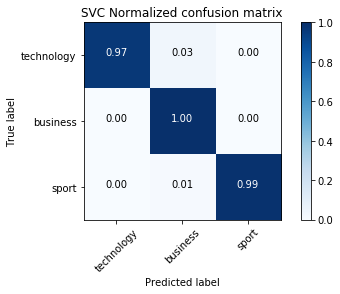

In [13]:
# Compute confusion matrix
cnf_matrix_Log = confusion_matrix(target_test, predicted_Log)
np.set_printoptions(precision=2)

#Cross Validation
acc_scores_Log =  cross_val_score(model_logistic, train_X, target_train, cv=50, scoring="accuracy")
print("Logistic: Mean cross-validation accuracy = %.4f" % acc_scores_Log.mean() )

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_Log, classes=target_names,
                      title='SVC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_Log, classes=target_names, normalize=True,
                      title='SVC Normalized confusion matrix')

plt.show()

# Report And Discussion

In [14]:
print("KNN: Mean cross-validation accuracy = %.4f" % acc_scores_KNN.mean() )
print("Bayes: Mean cross-validation accuracy = %.4f" % acc_scores_Bayes.mean() )
print("Logistic: Mean cross-validation accuracy = %.4f" % acc_scores_Log.mean() )

KNN: Mean cross-validation accuracy = 0.9510
Bayes: Mean cross-validation accuracy = 0.9778
Logistic: Mean cross-validation accuracy = 0.9768


It was observed over the three classifier evaluations that the business articles tended to give the largest error when predicting the output categories, while technology and sport articles were predicted with higher accuracy.

Each classifier was tested under a 50-fold cross validation. The Naive Bayes and the Logistic Regression classifiers performed the best and yielded similar accuracies (~98%) under the cross validation process. The Nearest Neighbour classifier still provided a high accuracy (~95%) but still performed the worst out of the three classifiers.